In [1]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/marketing_campaign.csv", sep = '\t')

¡Holaaaa!

Hace unos días vi este dataset en Kaggle y me impresiono la cantidad de personas que hace la misma cosa; implementar un algoritmo no supervisado (cluster) que te dice absolutamente nada de los datos pero que claro, agruparlos a través de distancias es algo fancy. El proposito de este proyecto es hacer algo diferente, quiero mostrarte lo que podemos lograr solo con analizar y relacionar variables teniendo en cuenta las necesidades del negocio. 

Este proyecto se hace bajo una situacion hipotetica pero que no esta lejos de la realidad. Cualquier warehouse con un modelado alineado al negocio puede darte estos datos o simplemente un experimento bien diseñado. El objetivo de este analisis es entender mas sobre las personas que nos compran y desarrollar nuestro target a mayor profundidad ya que nos puede servir como base para ir montando un qualitative feature map:

Alcance | Nombre | Descripción |
------------ | ------------ | ------------ |
Target population | Target description | Descripcion cualitativa de tu segmento objetivo para el feature |
User value | User problem description | Problema que resuelve el feature |
Business value | Business Impact | Valor añadido por el feature |



In [3]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [4]:
df.shape

(2240, 29)


# Clean data

## Paso 1.-

In [5]:
df.isnull().sum().head().sum()

24

In [6]:
### Quitar columnas que no sirven
df=df.drop(columns=["Z_CostContact", "Z_Revenue"],axis=1)

In [7]:
### Los valores nulos venian de la columna income. Lo que hice fue rellenarlos con el valor mediano de la distribucion
df['Income']=df['Income'].fillna(df['Income'].median())

In [8]:
df.isnull().sum().head().sum()

0

In [9]:
df['Marital_Status'].unique()

# Creo que algunas variables sobran así que voy a reformar cada cosa

array(['Single', 'Together', 'Married', 'Divorced', 'Widow', 'Alone',
       'Absurd', 'YOLO'], dtype=object)

In [10]:
df['Marital_Status'] = df['Marital_Status'].replace(['Together'],'FreeUnion')
df['Marital_Status'] = df['Marital_Status'].replace(['Divorced', 'Widow', 'Alone', 'YOLO', 'Absurd'],'Single')

Con esto hago una distincion importante. Separo en tres grupos: los casados, los solteros y los que tienen una relacion libre. 

In [11]:
df['Marital_Status'].unique()

array(['Single', 'FreeUnion', 'Married'], dtype=object)

In [12]:
### En este gran apartado solo estoy creando columnas producto de la suma de varias columnas. Con esto evito tanto dato.

df['Kids'] = df['Kidhome'] + df['Teenhome']
df['Expenses'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']
df['TotalAcceptedCMP'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5'] + df['Response']
df['NumPurchases'] = df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases'] + df['NumDealsPurchases']

In [13]:
### Con esto creo un diccionario que despues elimino 
col_del = ["AcceptedCmp1" , "AcceptedCmp2", "AcceptedCmp3" , "AcceptedCmp4","AcceptedCmp5", "Response","NumWebVisitsMonth", "NumWebPurchases","NumCatalogPurchases","NumStorePurchases","NumDealsPurchases" , "Kidhome", "Teenhome","MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds"]
df=df.drop(columns=col_del,axis=1)

In [14]:
### Lo ultimo que quiero hacer es cambiar algunas variables de education
df['Education'] = df['Education'].replace(['2n Cycle','Graduation', ],'Graduate')  
df['Education'] = df['Education'].replace(['Basic'], 'UnderGraduate')

In [15]:
### Tiempo de ver el resultado
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Dt_Customer,Recency,Complain,Kids,Expenses,TotalAcceptedCMP,NumPurchases
0,5524,1957,Graduate,Single,58138.0,04-09-2012,58,0,0,1617,1,25
1,2174,1954,Graduate,Single,46344.0,08-03-2014,38,0,2,27,0,6
2,4141,1965,Graduate,FreeUnion,71613.0,21-08-2013,26,0,0,776,0,21
3,6182,1984,Graduate,FreeUnion,26646.0,10-02-2014,26,0,1,53,0,8
4,5324,1981,PhD,Married,58293.0,19-01-2014,94,0,1,422,0,19


# Data analysis

## Paso 2.- 

#### En esta parte toca categorizar y aislar variables. Con esto puedo entender mas sobre mi dataset así como el volumen de cada variable y sus diferentes observaciones dentro del dataset

- Variable categorica:
    - Education
    - Marital_Status
    - Kids
    - Complain
    - TotalAcceptedCMP

- Variables continuas:
    - Year_Birth
    - Income
    - Dt_Customer
    - Recency
    - Expenses
    - NumPurchases

Una vez identificado, me gustaria empezar a entender el volumen de cada variable.

Mi principal interes esta en:
- Education
- Marital_Status
- Kids
- Income
- Year_Birth

Con esta primera fase puedo darme cuenta de lo siguiente:
- Que grado de educacion tiene el cliente
- Cual es su situacion marital
- Cuantos hijos tienen
- Cuanto ganan
- Donde esta la distribucion de nuestros clientes

**Esto me permite crear una primera base para mi futuro esquema y con ello ir definiendo a mis buyer personas.**

In [16]:
(
df["Education"]
    .value_counts(normalize=True)
    .mul(100)
    .round(1)
    .astype(str) + '%'
)

Graduate         59.4%
PhD              21.7%
Master           16.5%
UnderGraduate     2.4%
Name: Education, dtype: object

In [17]:
(
df["Marital_Status"]
    .value_counts(normalize=True)
    .mul(100)
    .round(1)
    .astype(str) + '%'
)

Married      38.6%
Single       35.5%
FreeUnion    25.9%
Name: Marital_Status, dtype: object

In [18]:
(
df["Kids"]
    .value_counts(normalize=True)
    .mul(100)
    .round(1)
    .astype(str) + '%'
)

1    50.4%
0    28.5%
2    18.8%
3     2.4%
Name: Kids, dtype: object

Text(0, 0.5, 'Acumulacion')

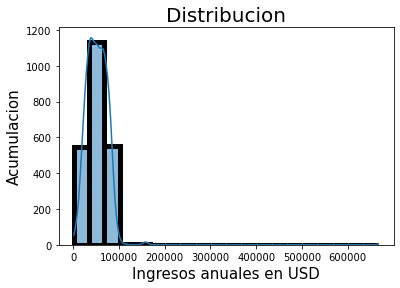

In [19]:
IncomeHist = sns.histplot(
            df, 
            x="Income",
            bins=20,
            linewidth=5, 
            kde = True)

IncomeHist.set_title("Distribucion", fontsize = 20)
IncomeHist.set_xlabel("Ingresos anuales en USD", fontsize = 15)
IncomeHist.set_ylabel("Acumulacion", fontsize = 15)

Text(0, 0.5, 'Acumulacion')

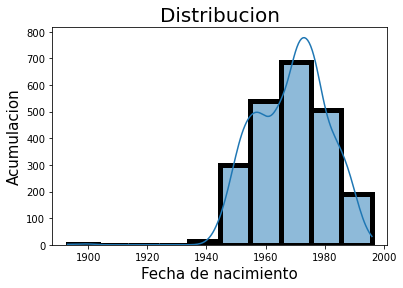

In [20]:
NacimientoHist = sns.histplot(
            df, 
            x="Year_Birth",
            bins=10,
            linewidth=5,
            kde = True)

NacimientoHist.set_title("Distribucion", fontsize = 20)
NacimientoHist.set_xlabel("Fecha de nacimiento", fontsize = 15)
NacimientoHist.set_ylabel("Acumulacion", fontsize = 15)

#### Relacion de variables.

Ahora que tengo un mayor contexto del dataset, mi siguiente paso es empezar a relacionar. Lo que quiero relacionar es esto:

- Variable categoricas y continuas que quiero relacionar
    - Education 
        - Kids °
        - Marital_Status °
        - TotalAcceptedCMP °
        - Income °
        - Year_Birthday °
        - Expenses °
        - NumPurchases °
        - Recency °
        
    - Marital Status
        - Expenses
        - Kids
        - TotalAcceptedCMP
        - NumPurchases
        - Recency
        
    - Kids
        - Expenses
        - TotalAcceptedCMP
        - NumPurchases
        - Recency
        



In [21]:
meanEduKids = df.groupby(['Education'])['Kids'].mean()
meanEduKids

Education
Graduate         0.930827
Master           0.989189
PhD              1.000000
UnderGraduate    0.722222
Name: Kids, dtype: float64

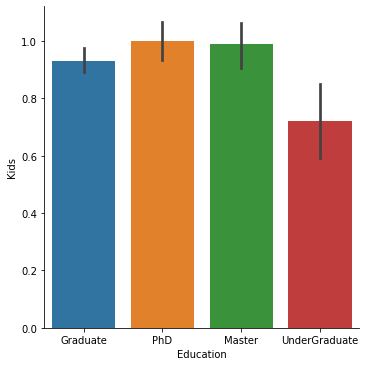

In [22]:
sns.catplot(x="Education", y="Kids", kind="bar", data=df)

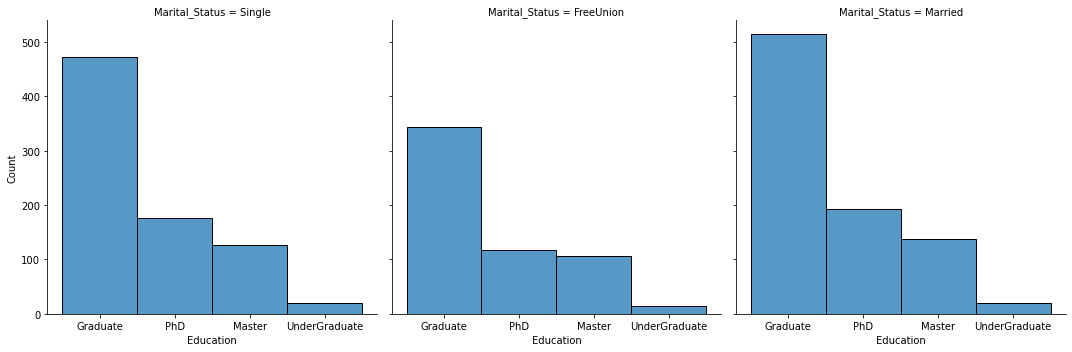

In [23]:
sns.displot(df,
           x="Education",
           col="Marital_Status")

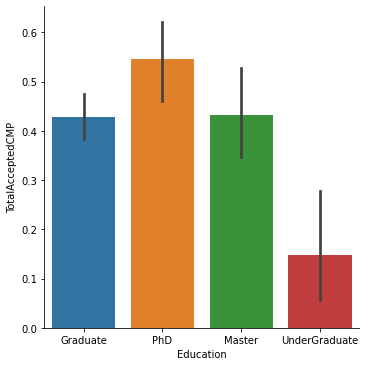

In [24]:
sns.catplot(x="Education", y="TotalAcceptedCMP", kind="bar", data=df)

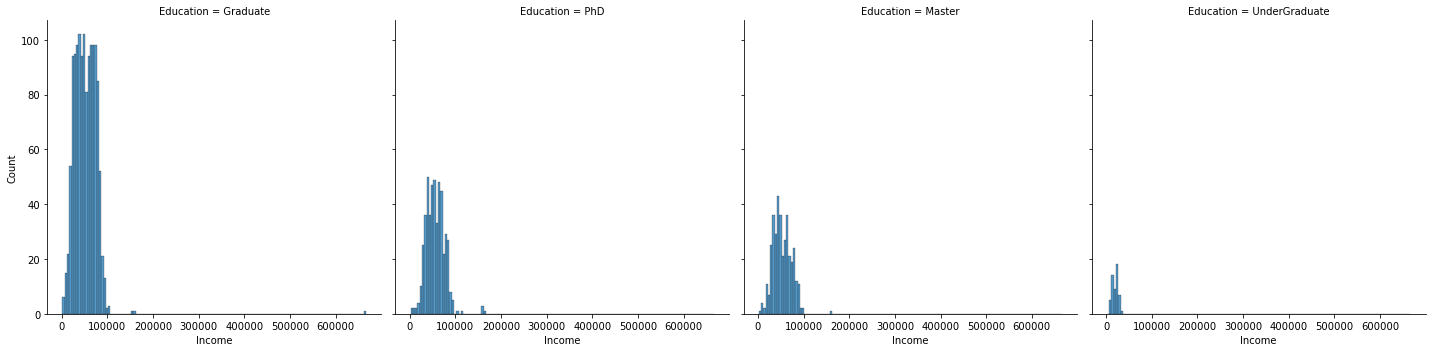

In [25]:
sns.displot(df, 
            x="Income", 
            col="Education")

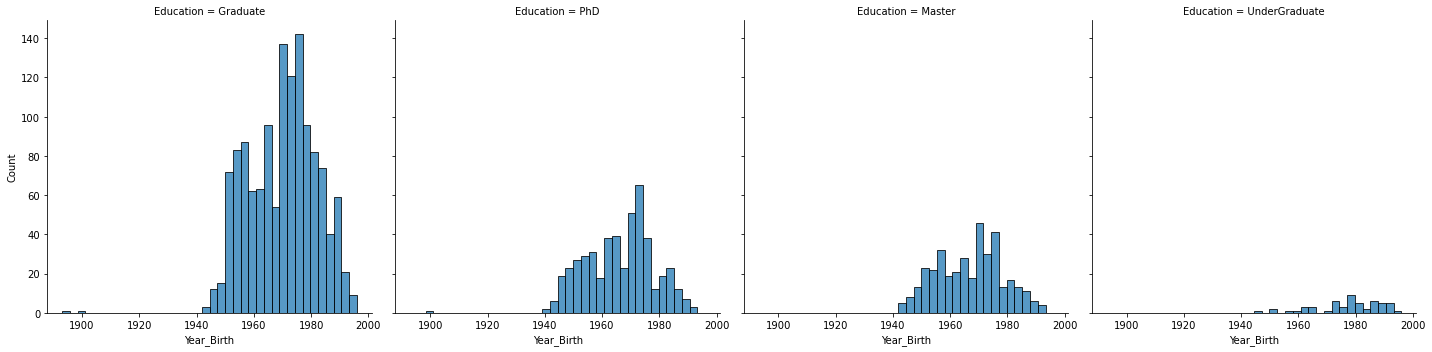

In [26]:
sns.displot(df,
           x="Year_Birth",
           col="Education")

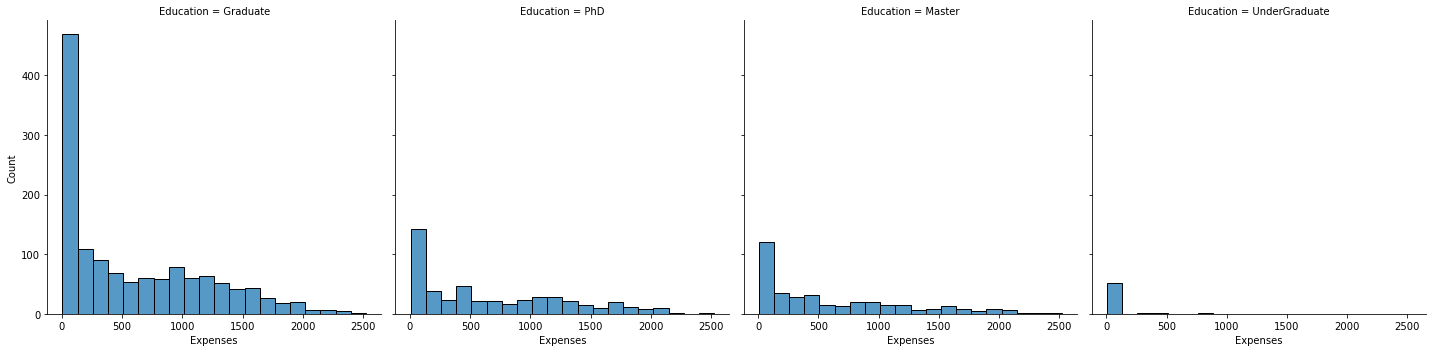

In [27]:
sns.displot(df,
           x="Expenses",
            bins=20,
           col="Education")

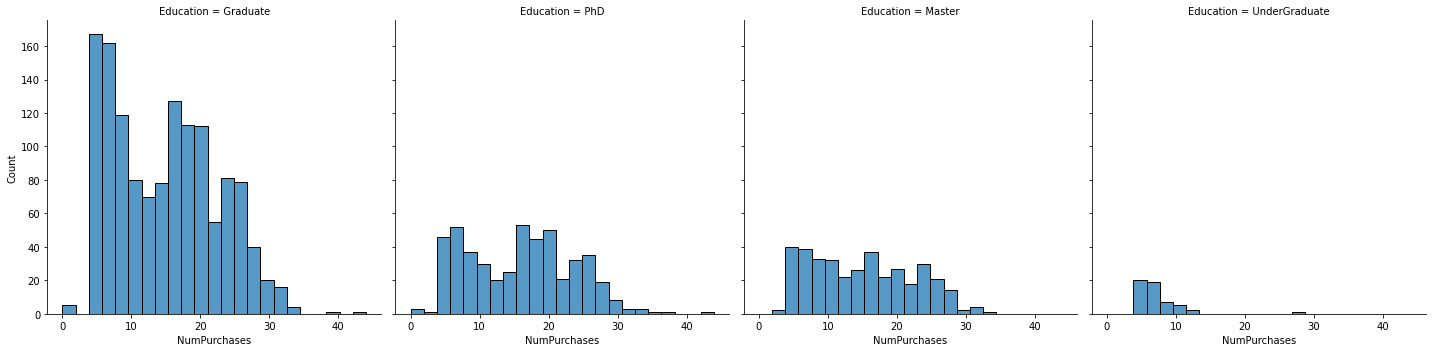

In [28]:
sns.displot(df,
           x="NumPurchases",
           col="Education")

## ¿Que sabemos hasta ahora?

- 

https://www.kaggle.com/imakash3011/customer-personality-analysis